In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from salad.models.phase1 import Phase1Model
from salad.models.phase2 import Phase2Model
from salad.models.language_phase1 import LangPhase1Model
from salad.models.language_phase2 import LangPhase2Model
from omegaconf import OmegaConf
import hydra
from salad.model_components.network import UnCondDiffNetwork, CondDiffNetwork
from salad.utils import visutil, imageutil
from salad.utils.spaghetti_util import *
from typing import Literal
from pytorch_lightning import seed_everything
device = "cuda:1"

def load_model(model_class: Literal["phase1", "phase2", "lang_phase1", "lang_phase2"], device):
    c = OmegaConf.load(f"../checkpoints/chair/{model_class}/hparams.yaml")
    model = hydra.utils.instantiate(c)
    ckpt = torch.load(f"../checkpoints/chair/{model_class}/state_only.ckpt")
    model.load_state_dict(ckpt)
    model.eval()
    for p in model.parameters(): p.requires_grad_(False)
    model = model.to(device)
    return model

# Load SPAGHETTI and Mesher

In [ ]:
spaghetti = load_spaghetti(device=device)
mesher = load_mesher(device=device)

# Load models

In [ ]:
lang_phase1_model = load_model("lang_phase1", device)
phase2_model = load_model("phase2", device)
#phase2_model = load_model("lang_phase2", device)

lang_phase1_model._build_dataset("val")

# Sample extrinsic parameters and intrinsic latents.

In [ ]:
seed_everything(63)
texts = ["an office chair", "a chair with armrests", "a chair without armrests", "a chair with a round back"]

# phase1 sampling
extrinsics = lang_phase1_model.sampling_gaussians(texts)

############ phase2 sampling ###############
intrinsics = phase2_model.sample(extrinsics)
############################################

### language conditioned phase2 sampling ###
#lang_f = phase2_model.text_to_embedding(texts)
#cond = phase2_model.cond_from_gaus_lang_f(gaussians, lang_f)
#intrinsics = phase2_model.sample(cond)
############################################

zcs = generate_zc_from_sj_gaus(spaghetti, intrinsics, extrinsics)

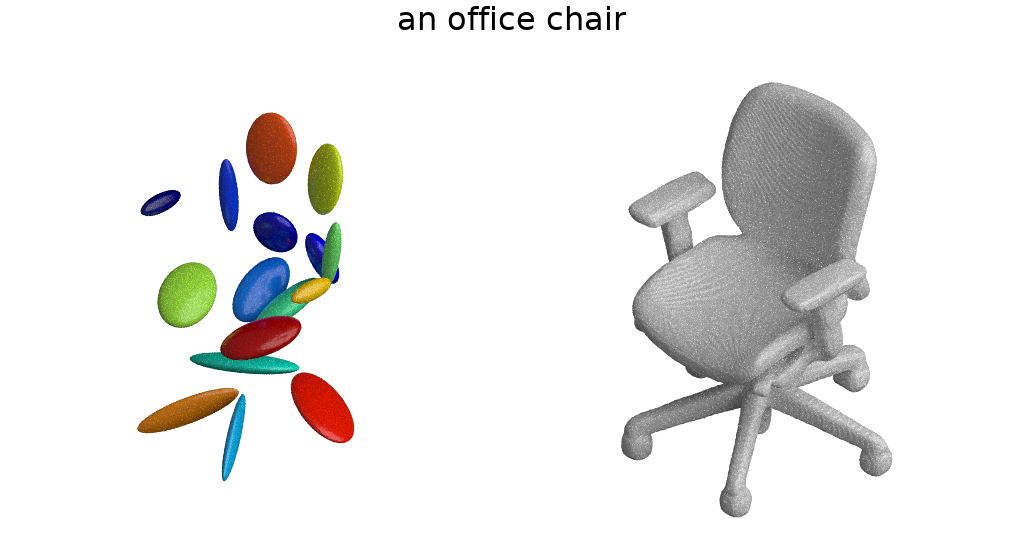

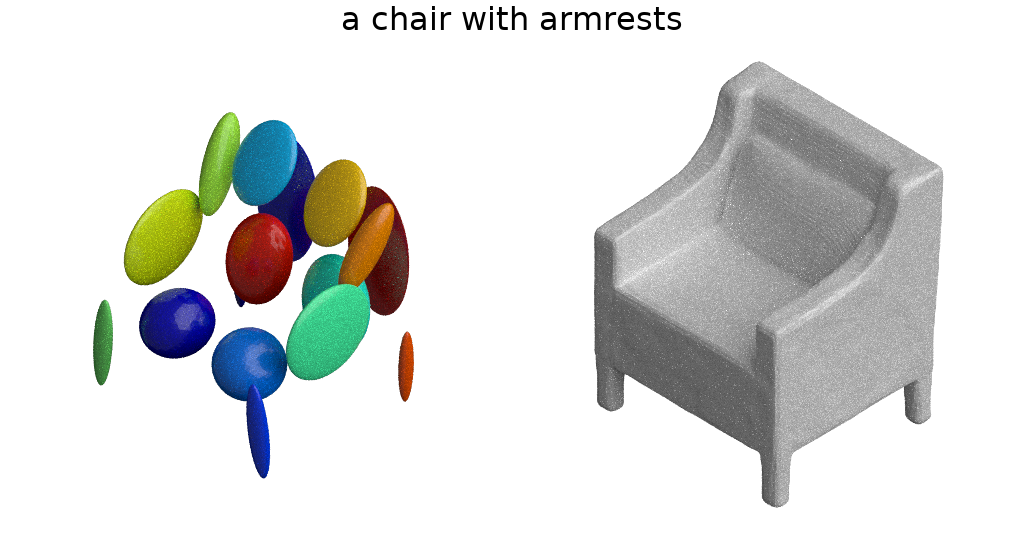

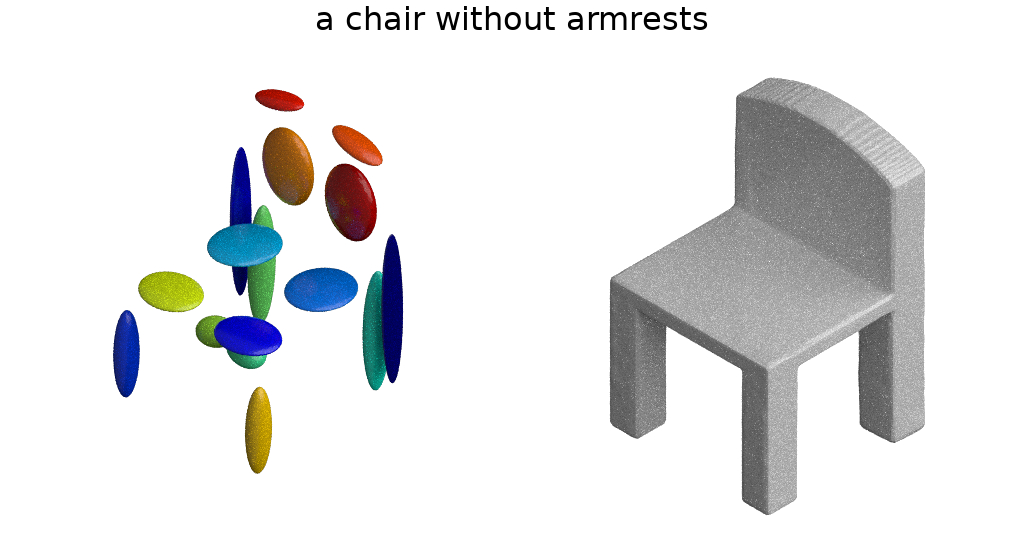

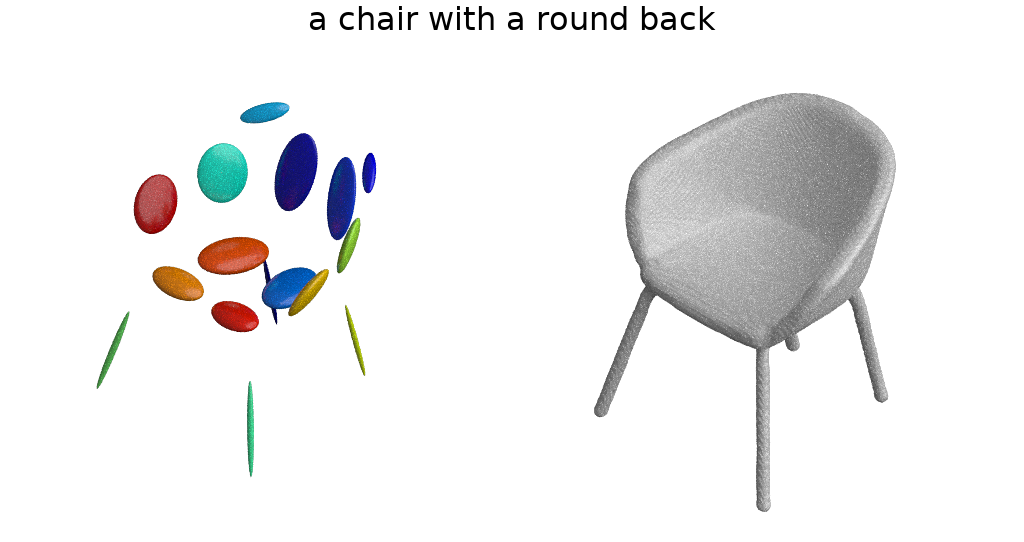

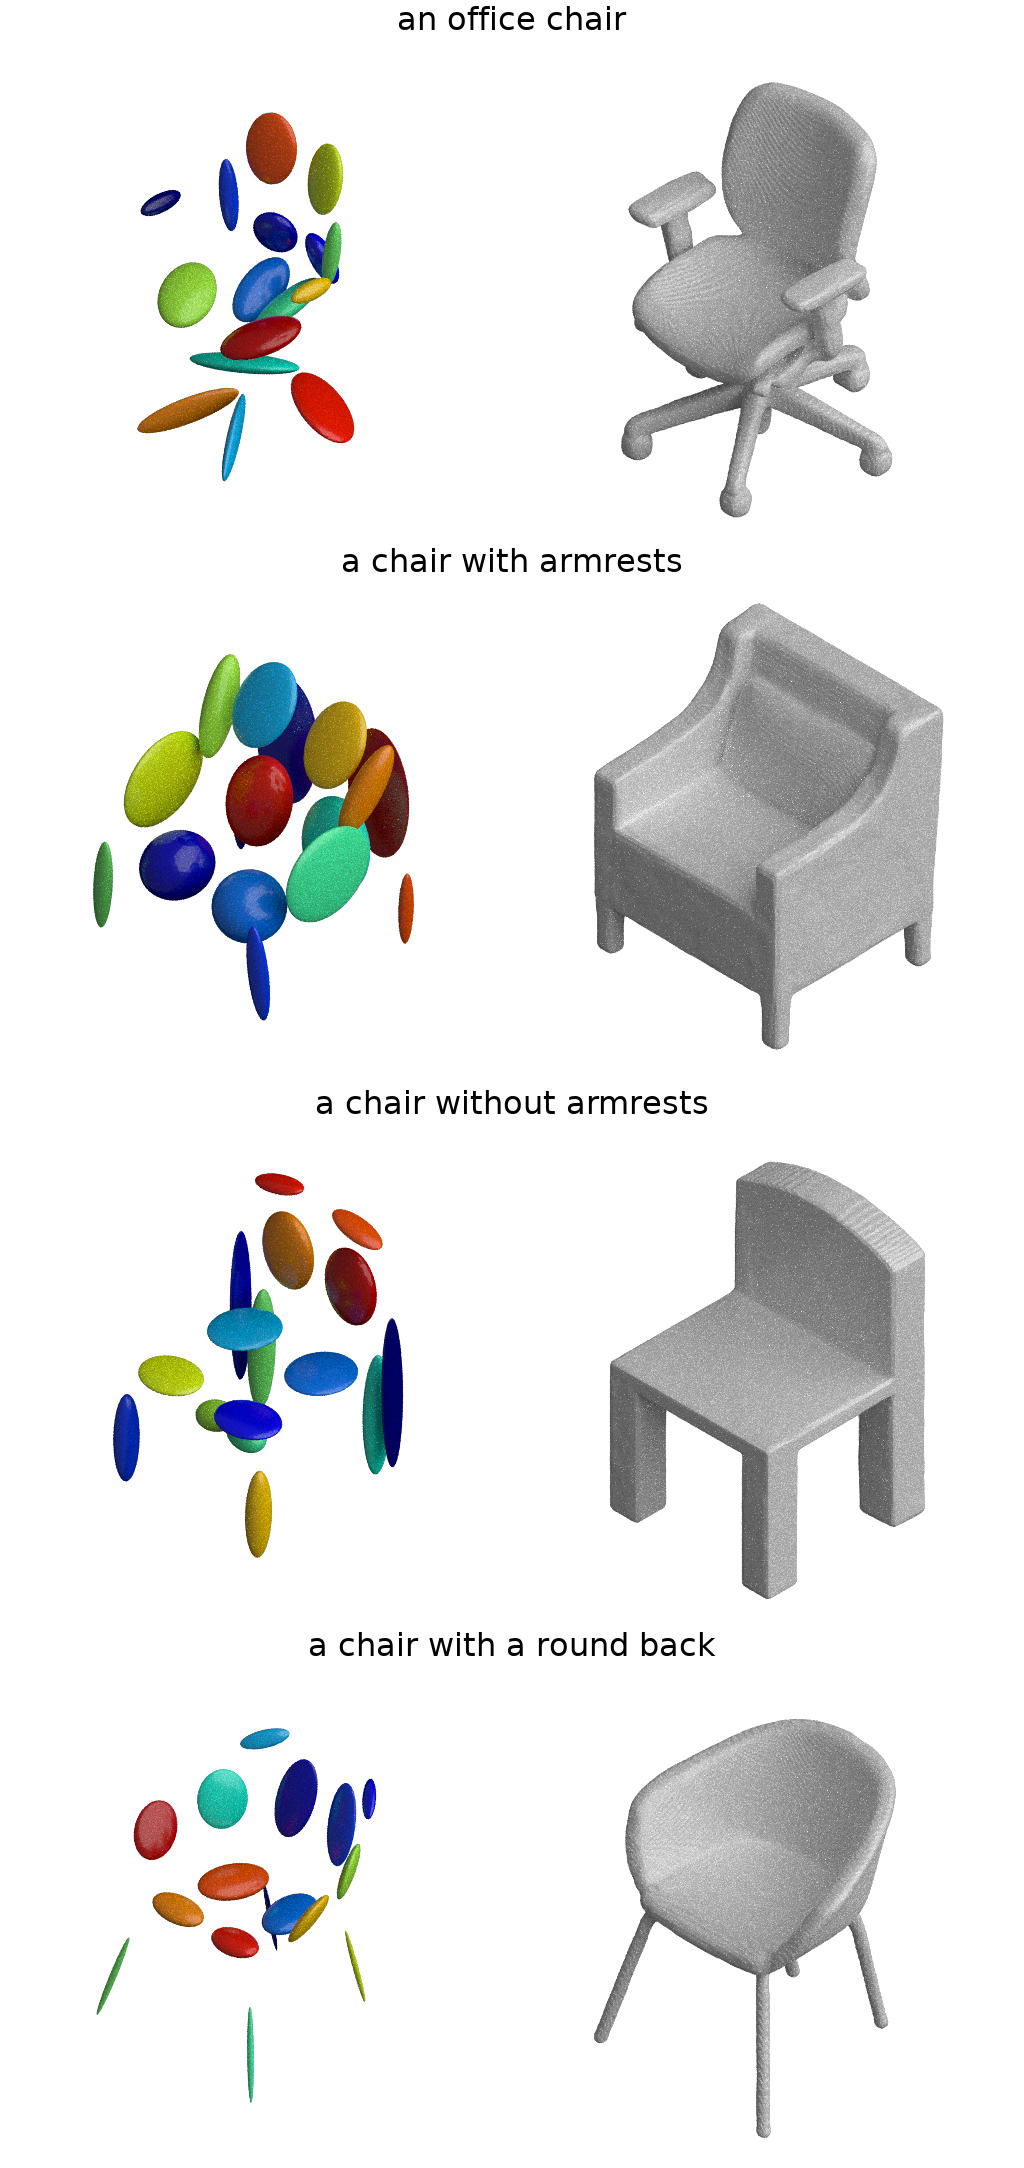

In [10]:
# visualize
images = []
for i in range(len(zcs)):
    gaus_img = visutil.render_gaussians(extrinsics[i])
    
    v, f = get_mesh_from_spaghetti(spaghetti, mesher, zcs[i], res=256)
    mesh_img = visutil.render_mesh(v, f)
    
    img = imageutil.merge_images([gaus_img, mesh_img])
    img = imageutil.draw_text(img, texts[i])
    display(img)
    images.append([img])
imageutil.merge_images(images)